# 基于LSTM的股票预测 

工作：数据处理和搭建一个LSTM模型进行预测

数据集：惠普1970到2017的股价格

In [1]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

d:\virtual-env\tfv1\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
dataset = pd.read_csv('D:\\数据集\\Data\Stocks\\hpq.us.txt')
df = dataset.sort_values('Date')

dataset.info()

print("数据长度：", len(dataset))
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12075 entries, 0 to 12074
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     12075 non-null  object 
 1   Open     12075 non-null  float64
 2   High     12075 non-null  float64
 3   Low      12075 non-null  float64
 4   Close    12075 non-null  float64
 5   Volume   12075 non-null  int64  
 6   OpenInt  12075 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 660.5+ KB
数据长度： 12075


,Date,Open,High,Low,Close,Volume,OpenInt
0,1970-01-02,0.30627,0.30627,0.30627,0.30627,2441124,0
1,1970-01-05,0.30627,0.31768,0.30627,0.31385,6219848,0
2,1970-01-06,0.31385,0.31385,0.30996,0.30996,4447522,0
3,1970-01-07,0.31385,0.31385,0.31385,0.31385,1872638,0
4,1970-01-08,0.31385,0.31768,0.31385,0.31385,4280330,0


* Open: 当日开盘价
* Close: 当日收盘价
* High：当日最高股价
* Low: 当日最高股价
* Volume：股票成交量
* OpenInt：未平仓量

## 数据可视化

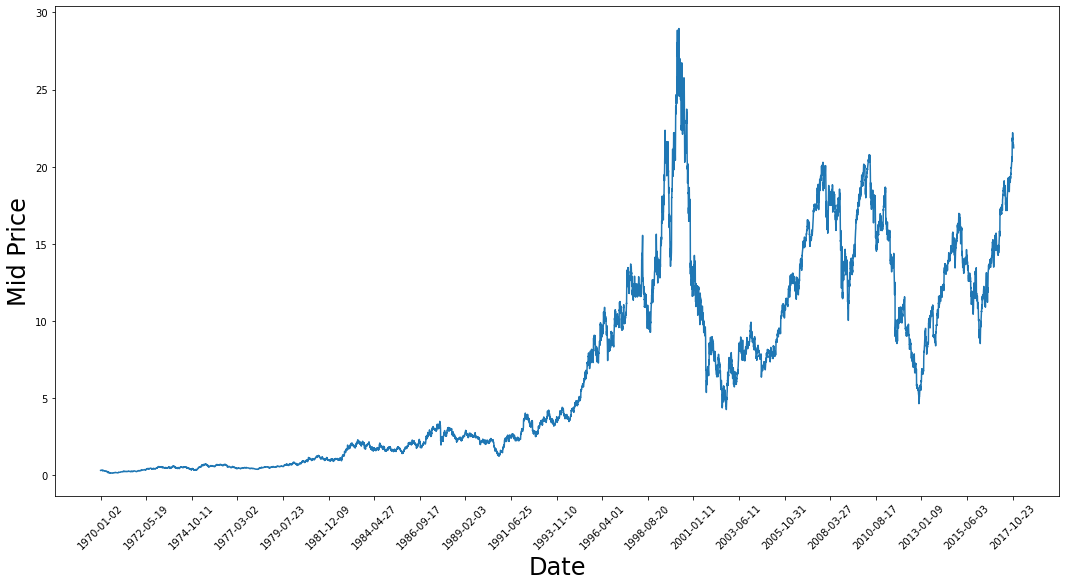

In [3]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],len(dataset)//20),df['Date'].loc[::len(dataset)//20],rotation=45)
plt.xlabel('Date',fontsize=24)
plt.ylabel('Mid Price',fontsize=24)
plt.show()

特点： 
1. 随着时间推移，股价变化巨大。
2. 接近2017年的价值比接近1970年代的价值高得多，并且波动更大。

## 拆分训练集和测试集

In [4]:
# 计算中间价格
high_prices = df.loc[:,'High'].to_numpy()
low_prices = df.loc[:,'Low'].to_numpy()
mid_prices = (high_prices+low_prices)/2.0

In [5]:
train_data = mid_prices[:11000]
test_data = mid_prices[11000:]

## 归一化

In [6]:
# 将最高价与最低价求均值，得到当天的均价
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [7]:
smoothing_window_size = 2500
for di in range(0,10000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

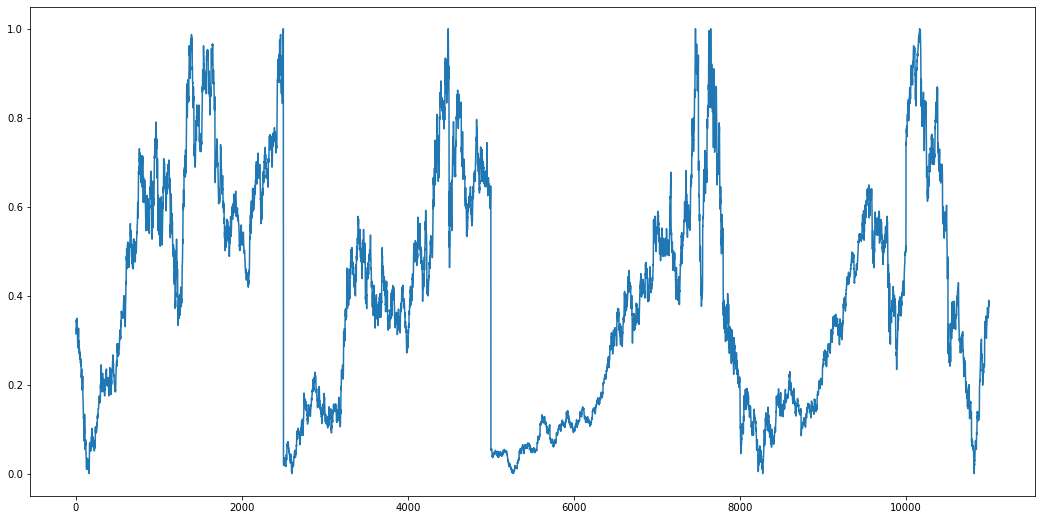

In [8]:
# 归一化后出现4个断点
plt.figure(figsize = (18,9))
plt.plot(train_data)

In [9]:
train_data = train_data.reshape(-1)
test_data = scaler.transform(test_data).reshape(-1)

指数移动平均值处理
抹平短期波动，反映出长期趋势

In [10]:
EMA = 0.0
gamma = 0.1
for ti in range(400):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

all_mid_data = np.concatenate([train_data,test_data],axis=0)

# Standard Average

![](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1525377205/sum_formula.png)

In [11]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00487


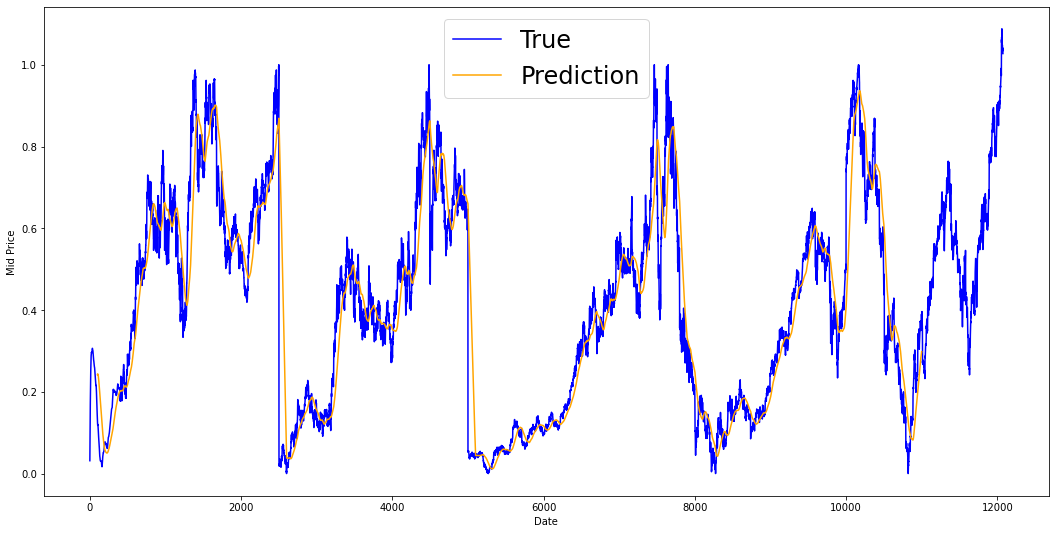

In [12]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=24)
plt.show()

# 指数移动平均

各数值的加权影响力随时间而指数式递减，越近期的数据加权影响力越重，但较旧的数据也给予一定的加权值。
![Snipaste_2020-04-16_10-39-52.png](https://i.loli.net/2020/04/16/LMS2cIlg1AGPkbt.png)
![Snipaste_2020-04-16_10-40-00.png](https://i.loli.net/2020/04/16/4vL2I1OWubPGtFa.png)

In [13]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00019


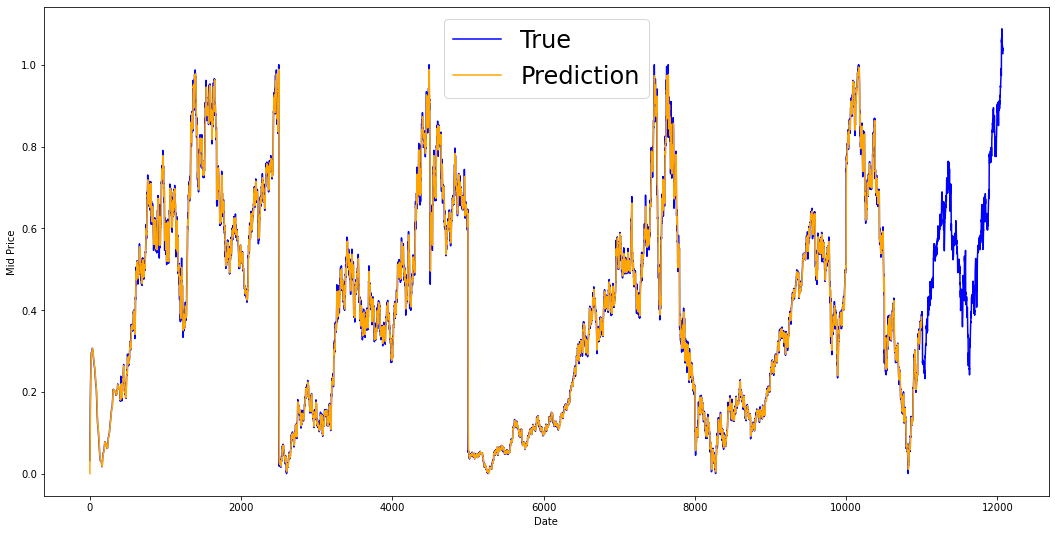

In [14]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=24)
plt.show()

实际上，仅凭第二天的股票市值就无法做很多事情。我们想要的不是第二天的确切股市价格，而是未来30天的股市价格会上涨还是下跌。

LSTM模型是个强大的时序模型，可以预测未来的任意数量的步骤

# LSTM

LSTM功能非常强大的时间序列模型,可以预测未来的任意数量的步骤。

input data: $[x_0,x_10,x_20,x_30], [x_1,x_11,x_21,x_31], [x_2,x_12,x_22,x_32]$

utput data: $[x_1,x_11,x_21,x_31], [x_2,x_12,x_22,x_32], [x_3,x_13,x_23,x_33]$

不能使$ x_t $的输出始终为$ x_{t + 1} $。而是从集合$ x_{t + 1}，x_{t + 2}，\ldots，x_ {t + N} $中随机采样输出，其中$ N $是一个很小的窗口大小。

In [15]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))


# 定义超参数

In [16]:
D = 1 # 数据维度
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.reset_default_graph() # This is important in case you run this multiple times

# 定义输入和输出

In [17]:
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

# 定义LSTM和回归层的参数

三层LSTM和一个线性回归层

w,b将获取最后一个Long Short-Term Memory单元的输出，并输出下一个时间步的预测。

In [18]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


计算LSTM输出并将其提供给回归层以获得最终预测

In [19]:
c, h = [],[]
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of
# a specific format.
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [20]:
print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
	All done


In [21]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


In [ ]:
epochs = 30
valid_summary = 1 # Interval you make test predictions

n_predict_once = 50 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings)

x_axis_seq = []

# Points you start your test predictions from
test_points_seq = np.arange(11000,12000,50).tolist()

for ep in range(epochs):       

    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):

        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))

      # The average loss
      if (ep+1) % valid_summary == 0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))

      train_mse_ot.append(average_loss)

      average_loss = 0 # reset loss

      predictions_seq = []

      mse_test_loss_seq = []

      # ===================== Updating State and Making Predicitons ========================
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []

        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]

        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_mid_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)

        feed_dict = {}

        current_price = all_mid_data[w_i-1]

        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)

        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)

          our_predictions.append(np.asscalar(pred))

          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2

        session.run(reset_sample_states)

        predictions_seq.append(np.array(our_predictions))

        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)

        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)

      current_test_mse = np.mean(mse_test_loss_seq)

      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0

      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')

      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')

Initialized
Average loss at step 1: 1.532306


d:\virtual-env\tfv1\lib\site-packages\ipykernel_launcher.py:94: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


	Test MSE: 0.00526
	Finished Predictions
Average loss at step 2: 0.193640
	Test MSE: 0.00769
	Finished Predictions


In [ ]:
plt.plot(test_mse_ot,color='red', label='mse')
plt.title('Training and validation error')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()

MSE损失与进行标准平均（0.004）时获得的MSE损失进行比较, 结果好很多。

In [ ]:
best_prediction_epoch = 28 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(df.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(11000,12500)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(df.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')

plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(11000,12500)
plt.show()

虽然不是很完美，但LSTM似乎能够在大多数时间正确预测股价行为